<a href="https://colab.research.google.com/github/NataliaPravosudova/GEC/blob/main/m2m100_ua_gec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install ua_gec transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21

In [21]:
from collections import defaultdict
from ua_gec import Corpus

import difflib as dl

import gc

import pandas as pd
import regex as re
import copy
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import get_linear_schedule_with_warmup

from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

model_name = 'alirezamsh/small100'

In [ ]:
corpus = Corpus(partition='test')

doc_0 = str(corpus.get_doc('0002').annotated)
doc_0

'Наступного ранку рівно {о=>об:::error_type=Spelling} одинадцятій годині, коли я сидів сам, дядько Том {шаштався=>шастав:::error_type=G/UngrammaticalStructure} {в=>у:::error_type=Spelling} готелі {і=>та:::error_type=F/Repetition} попросив у лікаря підійти і побачити Джанге Банк, {хто, воно =>:::error_type=G/UngrammaticalStructure}здавалось, це був {майор=>мер:::error_type=F/Calque} і дуже хворий чоловік.\n"Я не {є доктор"=>лікар:::error_type=F/Calque}{=>,:::error_type=Punctuation} {-=>—:::error_type=Punctuation} сказав я{: "=>. — :::error_type=Punctuation}Чому вам не піти до лікаря?".\n"Босс{"=>,:::error_type=Punctuation} {-=>—:::error_type=Punctuation} сказав він{: "=>. — :::error_type=Punctuation}Доктор Хоскінс має проїхати 20 миль по країні, щоб побачити хворих персон. Він {є=>—:::error_type=Punctuation} єдиний лікар {в=>у:::error_type=Spelling} місті і Масса банки сильно погано {обурудувані=>облаштовані:::error_type=F/Calque}. Він відправив {мені=>мене:::error_type=G/Case}, щоб спи

In [26]:
error_pattern = r'\{(([^\{]*\(*\)*)=>([^\{]*\(*\)*):::error_type=([^\{]*))\}'

In [23]:
split_pattern = r'\n+'

regex_special_symbols = {
                '(': '\(',
                ')': '\)',
                '?': '\?',
                '[': '\[',
                ']': '\]',
                '*': '\*',
                '$': '\$'
            }


corpus = Corpus(partition='all')
        
source_sentences = []
cleaned_sentences = []
errors_in_sentences = []

In [ ]:
for doc in corpus:
    
    document = str(doc.annotated)

    # Split document into chunks by new line
    splitted = [re.sub(r'\n+', ' ', e).strip() for e in re.split(split_pattern, document)]

    for sentence in splitted:

        # Replace special symbols and delete excess whitespaces 
        sentence = sentence.replace('\\', ' ')
        sentence = sentence.replace('/', ' ')
        sentence = sentence.strip()
            
        # Copy initial sentence 
        clean = sentence
        source_sentence = sentence

        # Find annotated errors in currect sentence / text chunk
        matches = re.finditer(error_pattern, sentence)

        errors = []

        for match in matches:
            
            # Complete annotation with curly brackets
            mistake = match.group(0)
            
            # Initial error
            source_mistake =  match.group(2)
            
            # Suggested correction
            correction =  match.group(3)
            
            # Error type
            err_type = match.group(4)
            
            errors.append(err_type)
            #errors = ['Style' if 'F' in s else s for s in errors]
            #print(errors)        
            
            # Replace RegEx special symbols
            for ss in regex_special_symbols.keys():
                if ss in mistake:
                    mistake = mistake.replace(ss, regex_special_symbols[ss])
                    correction = correction.replace(ss, regex_special_symbols[ss])
                    source_mistake = source_mistake.replace(ss, regex_special_symbols[ss]) 
            try:
                # Replace annotation with correction
                clean = re.sub(mistake, correction, clean)
            except:
                print(sentence, '\n\n', mistake, '\n\n', correction, '\n\n', clean)

            # Replace annotation with initial mistake
            source_sentence = re.sub(mistake, source_mistake, source_sentence)
           
            
        # Append lists with source sentences with errors, corrected sentences and the respective error types
        source_sentences.append(source_sentence)
        errors_in_sentences.append(sorted(set(errors)))
        cleaned_sentences.append(clean) 

In [ ]:
df = pd.DataFrame({'source': source_sentences,
                    'cleaned': cleaned_sentences,
                    'err': errors_in_sentences}) 

# Join errors in string
df['err'] = df.err.apply(lambda x: ', '.join(list(x)))

df

,source,cleaned,err
0,Byte for France або “Мій досвід ведення блогу ...,Byte for France або “Мій досвід ведення блогу ...,Spelling
1,Останні 3 місяці мого життя видалися аж занадт...,Останні 3 місяці мого життя видалися аж занадт...,"F Style, Punctuation"
2,Сьогодні розповім про те як і навіщо мене зане...,"Сьогодні розповім про те, як і навіщо мене зан...","Punctuation, Spelling"
3,Моє бачення Instagram,Моє бачення Instagram,
4,"Колись давно я прочитав статтю, чи просто коме...",Колись давно я прочитав статтю чи просто комен...,"F Calque, F Style, Punctuation, Spelling"
...,...,...,...
17360,,,
17361,Яким боком московити нам брати? І навіть якщо...,З якого це дива московити — нам брати? І навіт...,"F Style, Punctuation"
17362,,,
17363,"Якщо судити по автівці, то де Папа, а де якийс...","Якщо судити за автівкою, то де Папа, а де який...",G Prep


In [ ]:
del source_sentences
del cleaned_sentences
del errors_in_sentences

In [ ]:
df.loc[df.err == '', 'err'] = 'Correct docs'

err_value_counts = df['err'].value_counts()
err_value_counts

Correct docs                                                                                                      6077
Punctuation                                                                                                       2868
Punctuation, Spelling                                                                                              983
Spelling                                                                                                           738
F Style, Punctuation                                                                                               316
                                                                                                                  ... 
F Calque, F Collocation, F PoorFlow, G Case, G Gender, G Prep, G UngrammaticalStructure, Punctuation, Spelling       1
F Collocation, F Style, G Case, G Gender, G Prep, G UngrammaticalStructure, Punctuation, Spelling                    1
F Calque, F PoorFlow, F Style, G Case, G VerbVoi

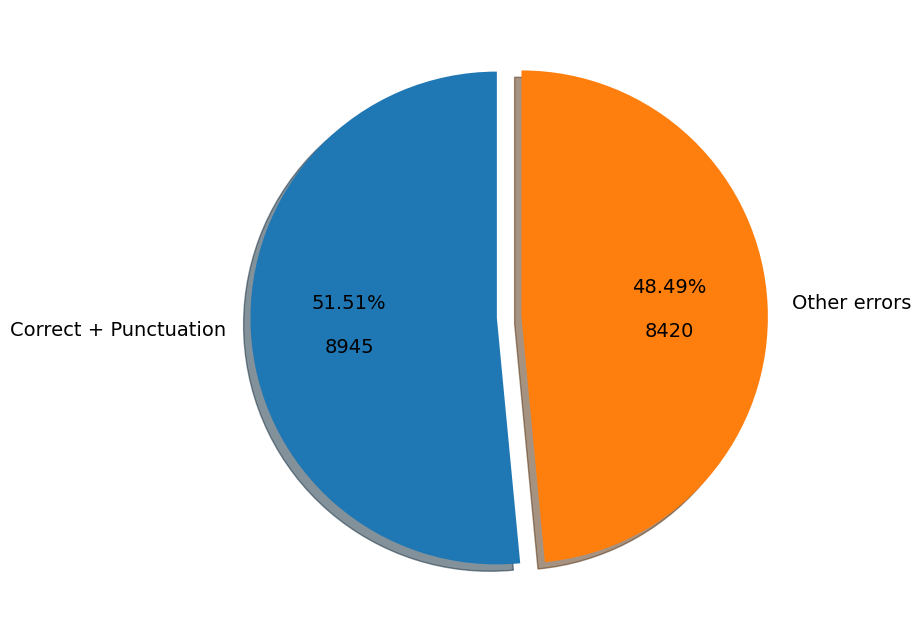

In [ ]:
# Count values of each pie piece
error_count = {
    'Correct + Punctuation': sum(err_value_counts[:2]),
    'Other errors': sum(err_value_counts[2:])
}


def format_pie_labels(x, sum_data):
    '''
    Helper function for formatting pie chart labels
    '''
    absol = int(x / 100 * sum_data)  
    return f'{x:.2f}%\n\n{absol}'


sum_data = np.sum(list(error_count.values()))

# Pie chart ----------------------------------------------------

fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)

ax.pie(list(error_count.values()),
       autopct = lambda x: format_pie_labels(x, sum_data),
       labels = error_count.keys(),
       shadow = True,
       textprops = dict(fontsize=14),
       startangle = 90,
       explode=[0, 0.1]
         )
                            

fig.show()

In [22]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("alirezamsh/small100", tgt_lang="uk")



Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


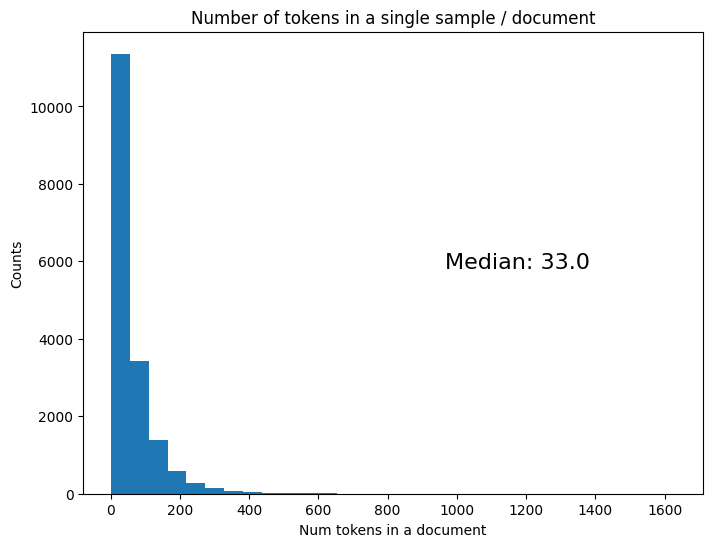

,source,cleaned,err,tokens,num_tokens
13449,"Актуальність теми дослідження обумовлена тим, ...","Актуальність теми дослідження зумовлена тим, щ...","F Calque, F PoorFlow, F Style, G Case, G Compa...","[128022, 532, 27581, 8085, 9614, 59971, 78337,...",1630
8034,При першій зустрічі з Гаррі Поттером Дамблдор ...,При першій зустрічі з Гаррі Поттером Дамблдор ...,"F Calque, F Collocation, F PoorFlow, F Repetit...","[128022, 2467, 4523, 4403, 623, 49640, 7989, 3...",1558
2005,"Ключі в руці, сигналізацію ввімкнено - можна р...","Ключі в руці, сигналізацію ввімкнено — можна р...","F Calque, F Other, F PoorFlow, F Style, Punctu...","[128022, 113465, 7989, 43, 3850, 2244, 4, 5406...",1314
14996,"Я все-таки напишу, скііільки зараз зможу і нас...","Я все-таки напишу, скііільки зараз зможу і нас...","F Calque, F PoorFlow, F Style, G Case, G Conju...","[128022, 2057, 2192, 7, 59005, 29143, 4400, 4,...",1204
8688,Останнім часом багато читаю про нашу нову полі...,Останнім часом багато читаю про нашу нову полі...,"F Calque, F Collocation, F PoorFlow, F Style, ...","[128022, 844, 5681, 46996, 105597, 28817, 1443...",1153


In [ ]:
def get_tokens(df):
    '''Get tokens in the DataFrame with column "cleaned".
    CREATES a column with number of tokens in the corrected sentence, 
    PRINTS histogram with distribution of tokens, 5 rows with greatest number of tokens.
    '''
    tokens, num_tokens = [], []
    for i in range(len(df)):
        t = tokenizer.encode(df.loc[i, 'cleaned'])
        tokens.append(t)
        num_tokens.append(len(t))

    df['tokens'] = tokens
    df['num_tokens'] = num_tokens
    
    # === Histogram ===
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.hist(df.num_tokens, bins=30)
    plt.text(0.7, 0.5, f'Median: {df.num_tokens.median()}', 
             transform=ax.transAxes, ha='center', va='center', size=16)
    plt.title('Number of tokens in a single sample / document')
    plt.ylabel('Counts')
    plt.xlabel('Num tokens in a document')
    plt.show()
    
    display(df.sort_values(by='num_tokens', ascending=False).head())
    
    
get_tokens(df)

In [ ]:
# Check if part of the error pattern is present in any documents
uncorrect = df[df.source.apply(lambda s: 'error_type' in s)]

if len(uncorrect.index) > 0:
    print('Uncorrectly parsed sentences:', uncorrect.index)
    df.drop(index=uncorrect.index, inplace=True)
    df.reset_index(drop=True, inplace=True)

Uncorrectly parsed sentences: Int64Index([1294, 2566, 3357, 16334], dtype='int64')


In [22]:
additional_split_pattern = r'(?<=.[.?!(\.\.\.)…]) +(?=[А-ЯІ“"])'

In [ ]:
max_tokens = 20

# Select long sentences with big number of tokens
indexes_long_sentenes = df[df['num_tokens'] > max_tokens].index

for i in indexes_long_sentenes:
    # Split the long sentences
    source_list = re.split(additional_split_pattern, df.loc[i, 'source'])
    target_list = re.split(additional_split_pattern, df.loc[i, 'cleaned'])
    
    for s1, s2 in zip(source_list, target_list):
        # Append the splitted sentences to the dataframe
        #df = df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
        #df = df.concat([s1, s2],names=['source','cleaned'], ignore_index=True)
        df = pd.concat([df,pd.DataFrame({'source': [s1], 'cleaned': [s2]})], ignore_index=True)

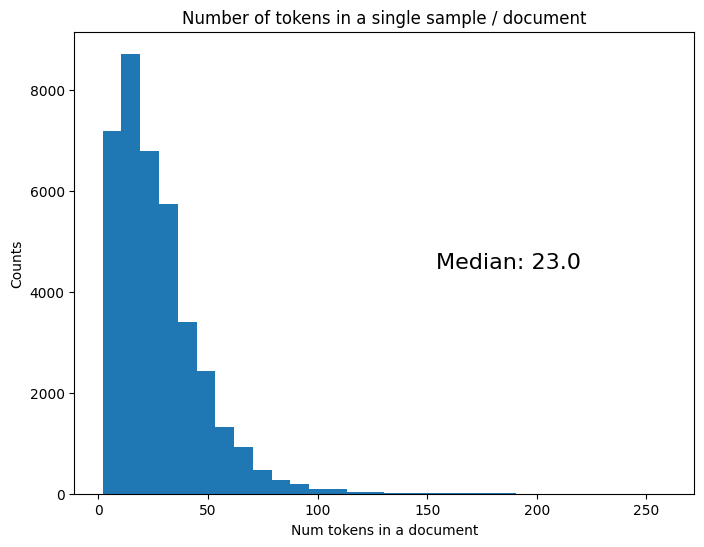

,source,cleaned,err,tokens,num_tokens
19275,"Він або вона має обожнювати кіно, і бути ветер...","Він або вона має обожнювати кіно, і бути ветер...",NaN,"[128022, 32092, 5858, 31551, 19649, 10347, 562...",259
30714,Вашингтон звинувачує Тегеран у підтримці режим...,За весь цей час відбувались певні короткострок...,NaN,"[128022, 1090, 51355, 40048, 6782, 23187, 4754...",242
16678,"Основні виклики: технічна база як в учителя, т...","Основні виклики: технічна база і у вчителя, і ...",NaN,"[128022, 30165, 27563, 819, 22786, 605, 9, 461...",237
7840,МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865-01.11...,МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865— 01.1...,NaN,"[128022, 50493, 1878, 17225, 62522, 14240, 187...",213
26750,"Танцювали свої і запрошені гості, московські і...","Танцювали свої і запрошені гості, московські і...",NaN,"[128022, 89078, 22820, 4353, 23747, 292, 27624...",212


In [ ]:
# Drop long sentences
df.drop(index=indexes_long_sentenes, inplace=True)
df.reset_index(drop=True, inplace=True)
get_tokens(df)

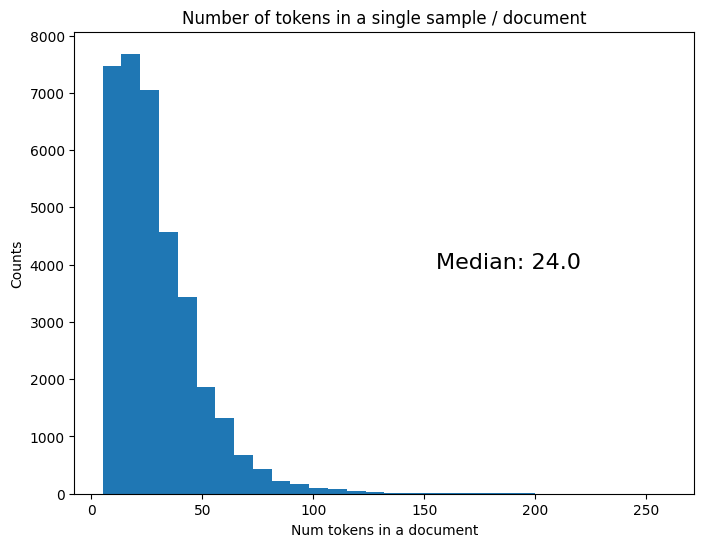

,source,cleaned,err,tokens,num_tokens
16871,"Він або вона має обожнювати кіно, і бути ветер...","Він або вона має обожнювати кіно, і бути ветер...",NaN,"[128022, 32092, 5858, 31551, 19649, 10347, 562...",259
28198,Вашингтон звинувачує Тегеран у підтримці режим...,За весь цей час відбувались певні короткострок...,NaN,"[128022, 1090, 51355, 40048, 6782, 23187, 4754...",242
14319,"Основні виклики: технічна база як в учителя, т...","Основні виклики: технічна база і у вчителя, і ...",NaN,"[128022, 30165, 27563, 819, 22786, 605, 9, 461...",237
5599,МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865-01.11...,МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865— 01.1...,NaN,"[128022, 50493, 1878, 17225, 62522, 14240, 187...",213
24262,"Танцювали свої і запрошені гості, московські і...","Танцювали свої і запрошені гості, московські і...",NaN,"[128022, 89078, 22820, 4353, 23747, 292, 27624...",212


In [ ]:
# Drop short sentences
df = df[df['num_tokens'] > 4]
df.reset_index(drop=True, inplace=True)

get_tokens(df)

In [ ]:
sorted_df = df.sort_values(by='num_tokens', ascending=False)

for i in range(5):
    print(f'{sorted_df.iloc[i, 0]}\n\n')

Він або вона має обожнювати кіно, і бути ветераном у відвідуванні кінотеатру, і добре володіти термінологією та жаргоном у галузі кінематографії (наприклад, дальній заявочний план, нахил, операторський кран, закадровий голос, "за кадром", swish pan (вид панорамування), перебивка, великий план тощо), бути обізнаним у проблемах режисерської роботи, монтажу, роботи художника-постановника (вибір об'єктивів, мізасцена, освітлення, звукові ефекти, декорації, грим, саундтрек), знати історію кінематографу, нові тренди, зірок, назви та роки прем'єр фільмів, різноманітні жанри фільмів (наприклад, комедія, мелодрама, хоррор, трилер, екшн, класичний кінематограф, мюзикл, фільм-нуар, документальний фільм, вестерн, неореалізм, експресіонізм, нова хвиля тощо).


Вашингтон звинувачує Тегеран у підтримці режиму Башара Асада в Сирії, розпалюванні громадянської війни в Ємені, підтримці руху Хезболла та, в цілому, тероризму в регіоні й невиконанні 12 «основних вимог» JCPOA [2].


Основні виклики: технічна

In [ ]:
corpus = None; del corpus
df = None; del df
sorted_df = None; del sorted_df
gc.collect()

12728

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSeq2SeqLM.from_pretrained("alirezamsh/small100")
model = model.to(device)


model.resize_token_embeddings(len(tokenizer))

Embedding(128104, 1024)

In [24]:
num_epochs = 25
batch_size = 16
learning_rate = 0.0001
max_token_length = 50

In [ ]:
tokenizer.tokenize('світ ловив мене та не спіймав')

['▁світ', '▁', 'лови', 'в', '▁мене', '▁та', '▁не', '▁спі', 'йма', 'в']

In [24]:
class Parallel_Dataset(Dataset):
    '''
    A class to create a custom PyTorch dataset of parallel pairs of sentences (correct - incorrect).
    
    ...
    
    Attributes
    ----------
    partition : str
        partition of the UA-GEC corpus ('all' / 'test' / 'train')
    tokenizer : obj
        instance of a HuggingFace tokenizer
    max_token_length : int
        number of max tokens in a sample
    max_tokens : int
        number of tokens for splitting long sentences
    delete_correct_samples : bool
        delete pairs with sentences without errors if True
    
    Methods
    -------
    _del_rows(indexes)
        Deletes rows and resets indexes in self.df
    _get_df_from_uagec_corpus(partition)
        Create a DataFrame with source and target sentences
    _get_tokens()
        Calculate number of tokens in each sentence, add or rewrite column
    _check_incorrect_parced()
        Check if any of the sentences were incorrectly parsed
    _prepare_data
        Uses previously mentioned methods to prepare data
    __getitem__(index)
        Returns tokenized sentences as arrays of token ids
    '''

    def __init__(self, partition, tokenizer, max_token_length, max_tokens=20, delete_correct_samples=False):
        self.tokenizer = tokenizer
        self.max_token_length = max_token_length
        self.df = None
        
        # Load and preprocess UA-GEC corpus when instatiating an object of a class 
        self._prepare_data(partition, delete_correct_samples, max_tokens)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        batch = {}
        current_row = self.df.iloc[index]
        input_sentence = current_row['source']
        target_sentence = current_row['cleaned']
        
        inputs = self.tokenizer(input_sentence, 
                                         return_tensors='pt',
                                         padding = 'max_length',
                                         truncation = True,
                                         max_length = self.max_token_length)
        outputs = self.tokenizer(target_sentence, 
                                         return_tensors='pt',
                                         padding = 'max_length',
                                         truncation = True,
                                         max_length = self.max_token_length)
        
        batch["input_ids"] = inputs.input_ids.flatten()
        batch["attention_mask"] = inputs.attention_mask.flatten()
        batch["labels"] = outputs.input_ids.flatten()
       
        return batch
    
     # === Helper functions ===

    def _del_rows(self, indexes):
        '''Deletes rows by given indexes in self.df with index reset.'''
        self.df.drop(index=indexes, inplace=True)
        self.df.reset_index(drop=True, inplace=True) 
        
    
    def _get_df_from_uagec_corpus(self, partition):
        '''Load UA-GEC corpus and create a DataFrame with source and target sentences.'''
        
        # Load UA-GEC corpus
        corpus = Corpus(partition=partition)
        
        source_sentences = []
        cleaned_sentences = []
        errors_in_sentences = []
        
        # Iterate through every document in corpus
        for doc in tqdm(corpus, total=len(corpus), desc='Loading corpus...', colour='#67597a'):
            
            # Convert document to string
            document = str(doc.annotated)
            
            # Split document into chunks by new line
            splitted = [re.sub(r'\n+', ' ', e).strip() for e in re.split(split_pattern, document) if e]

            for sentence in splitted:
                # Replace special symbols and delete excess whitespaces 
                sentence = sentence.replace('\\', ' ')
                sentence = sentence.replace('/', ' ')
                sentence = sentence.strip()
            
                # Copy initial sentence
                clean = sentence
                source_sentence = sentence

                # Find annotated errors in currect sentence / text chunk
                matches = re.finditer(error_pattern, sentence, re.MULTILINE | re.UNICODE | re.VERBOSE)

                errors = []

                for match in matches:
                    # Complete annotation with curly brackets 
                    mistake = match.group(0)

                    # Initial error 
                    source_mistake =  match.group(2)

                    # Suggested correction 
                    correction =  match.group(3)

                    # Error type 
                    err_type = match.group(4)
                    errors.append(err_type)       
                
                    # Replace RegEx special symbols
                    for ss in regex_special_symbols.keys():
                        if ss in mistake:
                            mistake = mistake.replace(ss, regex_special_symbols[ss])
                            correction = correction.replace(ss, regex_special_symbols[ss])
                            source_mistake = source_mistake.replace(ss, regex_special_symbols[ss]) 
                    try:
                        # Replace annotation with correction
                        clean = re.sub(mistake, correction, clean)
                    except:
                        print(sentence, '\n\n', mistake, '\n\n', correction, '\n\n', clean)

                    # Replace annotation with initial mistake
                    source_sentence = re.sub(mistake, source_mistake, source_sentence)

                # Append lists with source sentences with errors, corrected sentences and the respective error types
                source_sentences.append(source_sentence)
                errors_in_sentences.append(set(errors))
                cleaned_sentences.append(clean) 

        self.df = pd.DataFrame({'source': source_sentences,
                                'cleaned': cleaned_sentences,
                                'err': errors_in_sentences}) 
        
        self.df['err'] = self.df.err.apply(lambda x: ', '.join(list(x)))
        
        print('Corpus loaded!')
        
    
    def _get_tokens(self):
        '''Create or rewrite column with number of tokens in the source sentence.'''
        num_tokens = []
        num_documents = len(self.df)
        
        # Iterate through every document in the dataframe
        for i in range(num_documents):
            # Tokenize source sentences
            t = self.tokenizer.tokenize(self.df.loc[i, 'cleaned'])
            # Calculate and append number of tokens to list
            num_tokens.append(len(t))
        # Create / rewrite column in dataframe
        self.df['num_tokens'] = num_tokens
        
    
    def _check_incorrect_parced(self):
        '''Check if part of the error pattern is present in any documents'''
        
        uncorrect = self.df[self.df.source.apply(lambda s: 'error_type' in s)]
        num_incorrect = len(uncorrect.index)
        if num_incorrect > 0:
            # Print and remove incorrectly parced sentences
            print('Uncorrectly parsed sentences:', uncorrect.index)
            self._del_rows(uncorrect.index)
     
    # === Main function to preprocess data ===
    
    def _prepare_data(self, partition, delete_correct_samples, max_tokens):
        '''Load and preprocess corpus.'''
        
        # Create a dataframe
        self._get_df_from_uagec_corpus(partition)
        
        # Delete pairs with sentences without errors
        if delete_correct_samples:
            no_errors_index = self.df[self.df.err == ''].index
            self._del_rows(no_errors_index)

        # Check if any of the sentences were incorrectly parsed
        self._check_incorrect_parced()
        
        # Calculate number of tokens in each sentence
        self._get_tokens()

        # Select long sentences with big number of tokens
        indexes_long_sentenes = self.df[self.df['num_tokens'] > max_tokens].index
        for i in indexes_long_sentenes:
            # Split the long sentences
            source_list = re.split(additional_split_pattern, self.df.loc[i, 'source'])
            target_list = re.split(additional_split_pattern, self.df.loc[i, 'cleaned'])
            # Append splitted source and target sentences to dataframe
            for s1, s2 in zip(source_list, target_list):
                #self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
                self.df = pd.concat([self.df,pd.DataFrame({'source': [s1], 'cleaned': [s2]})], ignore_index=True)
        
        # Delete long sentences splitted previously
        self._del_rows(indexes_long_sentenes)
        
        # Recalculate tokens
        self._get_tokens()
        
        # Remove short sentences
        short_sent_index = self.df[self.df['num_tokens'] < 4].index
        
        self._del_rows(short_sent_index)
        
        print(f'{partition.title()} dataset loaded!')
        print(f'Length of {partition} dataset = {len(self.df)}\n' + '='*80)

In [27]:
# Create test and train datasets by using the corresponding partition of the UA-GEC corpus 
dataset_test = Parallel_Dataset(partition='test', tokenizer=tokenizer, max_token_length=max_token_length, delete_correct_samples=True)
dataset_train = Parallel_Dataset(partition='train', tokenizer=tokenizer, max_token_length=max_token_length, delete_correct_samples=True)

Loading corpus...:   0%|          | 0/332 [00:00<?, ?it/s]

Corpus loaded!
Uncorrectly parsed sentences: Int64Index([158, 427, 522], dtype='int64')
Test dataset loaded!
Length of test dataset = 4304


Loading corpus...:   0%|          | 0/1749 [00:00<?, ?it/s]

Corpus loaded!
Uncorrectly parsed sentences: Int64Index([8923], dtype='int64')
Train dataset loaded!
Length of train dataset = 25255


In [ ]:
dataset_train.df.tail(30)

,source,cleaned,err,num_tokens
25225,Наніч печиво чудово мені замінює заспокійливе.,На ніч печиво чудово мені замінює заспокійливе.,NaN,17
25226,"Тобто замінювало, поки мені одного разу не ста...","Тобто замінювало, поки мені одного разу не ста...",NaN,16
25227,"Тато негайно повіз мене до ветеринара, де ліка...","Тато негайно повіз мене до ветеринара, де ліка...",NaN,63
25228,"Сказали, що собакам потрібні білки, а не вугле...","Сказали, що собакам потрібні білки, а не вугле...",NaN,18
25229,"Я з цього зрозуміла лише, що печива мені більш...","Я з цього зрозуміла лише, що печива мені більш...",NaN,23
25230,"Але сум змінила радість, коли мене почали част...","Але сум змінила радість, коли мене почали част...",NaN,24
25231,"Буду безмежно вдячна, якщо розповісте друзям п...","Буду безмежно вдячна, якщо розповісте друзям п...",NaN,21
25232,"друзі, помітила дивну активність зі свого екау...","Друзі, помітила дивну активність зі свого акау...",NaN,32
25233,▪️ Бути терпимішими до помилок.,▪️ Бути терпимішими до помилок.,NaN,12
25234,"Там, за стійкою у готелі, стоїть жива людина, ...","Там, за стійкою у готелі, стоїть жива людина, ...",NaN,53


In [ ]:
# Create instances of the optimizer and the dataloader(s)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

# Total number of training iterations = num_epochs * num_batches
total_steps = num_epochs * len(dataloader_train)

# Num steps during which lr increases linearly from 0 to the initial lr 
n_warmup_steps = int(total_steps * 0.01)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
from torch.optim.lr_scheduler import _LRScheduler

class LinearLR(_LRScheduler):
    """
    Linearly increases the learning rate from `start_lr` to `end_lr` over the specified number of iterations.
    """

    def __init__(self, optimizer, start_lr, end_lr, total_iters):
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.total_iters = total_iters
        super(LinearLR, self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        lr = self.start_lr + (self.end_lr - self.start_lr) * (curr_iter / self.total_iters)
        return [lr for _ in self.optimizer.param_groups]


def find_learning_rate(model, optimizer, dataloader, init_lr=0.000001, final_lr=0, num_iters=25, device='cuda'):
    """
    Find the optimal learning rate for a given model and optimizer.
    The learning rate is gradually increased from `init_lr` to `final_lr` during training.

    Args:
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        dataloader (torch.utils.data.DataLoader): The data loader for training data.
        init_lr (float, optional): The initial learning rate. Defaults to 1e-7.
        final_lr (float, optional): The final learning rate. Defaults to 10.
        num_iters (int, optional): The number of iterations to train for. Defaults to 100.
        device (str, optional): The device to use for training. Defaults to 'cuda'.

    Returns:
        list, list: Two lists containing the learning rates and corresponding losses.
    """
    model.to(device)
    model.train()

    lr_finder_lr = []
    lr_finder_loss = []

    lr_scheduler = LinearLR(optimizer, init_lr, final_lr, num_iters)  # Use the custom learning rate scheduler

    # Perform the learning rate search
    for i, batch in enumerate(dataloader):
        if i >= num_iters:
            break

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the learning rate and loss
        lr_finder_lr.append(lr_scheduler.get_lr()[0])
        lr_finder_loss.append(loss.item())

        # Step the learning rate scheduler
        lr_scheduler.step()

    return lr_finder_lr, lr_finder_loss


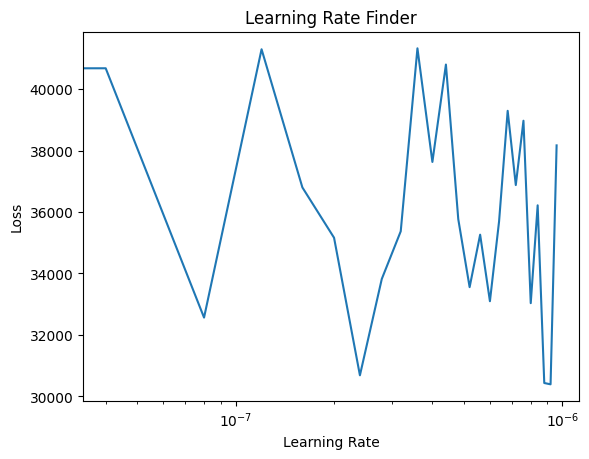

In [ ]:
import matplotlib.pyplot as plt

# Initialize your model, optimizer, and data loader
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Find the optimal learning rate
lr_finder_lr, lr_finder_loss = find_learning_rate(model, optimizer, dataloader)

# Plot the learning rate curve
plt.plot(lr_finder_lr, lr_finder_loss)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')
plt.show()


In [ ]:
def train(model, num_epochs, optimizer, dataloader_train, dataloader_val=None, scheduler=None):
    """
    Train a ML model and return its best weights alongside with the loss dictionary.
    """    
    
    history = {
        'loss': [],
        'val_loss': [],
        'smallest_val_loss': (0,0)
    }
    
    n_batches = len(dataloader_train)
    if dataloader_val:
        n_batches_val = len(dataloader_val)
    
    # Copy initial model weights
    best_model_weights = copy.deepcopy(model.state_dict())
    
    smallest_loss = np.inf
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        # === Training ===
        
        # Set model in training mode
        model.train()
        
        # Set loss of the current epoch to 0
        epoch_loss_train = 0
       
        # Iterate through batches in train dataloader
        for batch in tqdm(dataloader_train, total=n_batches, desc='Training...'):
            
            input_ids = batch["input_ids"] 
            attention_mask = batch["attention_mask"] 
            labels = batch["labels"] 

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            # Empty gradients
            # (PyTorch accumulates the gradients on subsequent backward passes)
            optimizer.zero_grad()
            
            # Forward pass 
            out = model.forward(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
            
            # Get the mean loss of the batch
            loss = out.loss
            
            # Add average batch loss
            epoch_loss_train += loss.item()
            
            # Calculate gradients (backpropagation)
            loss.backward()
            
            # Update model's weigths
            optimizer.step()
        
            # Update learning weight
            if scheduler is not None:
                scheduler.step()
            
        # Add current epoch loss to history
        epoch_loss_train /= n_batches
        history['loss'].append(epoch_loss_train)         
        
        # === Evaluation ===
        
        if dataloader_val is not None:
            
            epoch_loss_val = 0
            
            # Set model in  model in evaluation
            model.eval()
            
            # Disable gradient calculation
            with torch.no_grad():
                for batch in tqdm(dataloader_val, total=n_batches_val, desc='Performing evaluation...',  colour='#fb5607'):
                    
                    input_ids = batch["input_ids"] 
                    attention_mask = batch["attention_mask"] 
                    labels = batch["labels"] 

                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    labels = labels.to(device)
                    
                    out = model.forward(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
                    
                    loss = out.loss
                    
                    epoch_loss_val += loss.item()
            
            epoch_loss_val /= n_batches_val
            history['val_loss'].append(epoch_loss_val)
            
            # If current epoch loss is smaller than the previous one
            # Save current weights of the model, save loss as smallest
            if epoch_loss_val < smallest_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                smallest_loss = epoch_loss_val
                history['smallest_val_loss'] = (epoch, smallest_loss)
                print('Smallest loss, weights saved!')
        
        print(f'Train loss: {epoch_loss_train} | Val loss: {epoch_loss_val}') if dataloader_val else print(f'Train loss: {epoch_loss_train}')
        print('=' * 80 + '\n')
                   
    # Save best weights, last weights of the model
    # Note: if no validation dataloader is given, initial weights are returned 
    history['best_model_wts'] = best_model_wts
    history['last_model_wts'] = copy.deepcopy(model.state_dict())
    
    # Load best weights and return model 
    if dataloader_val is not None:   
        model.load_state_dict(best_model_wts)
        
    return model, history
      
        
#model, history = train(model, num_epochs, optimizer, dataloader_train, dataloader_test, scheduler=scheduler)

In [ ]:
# Call the train function
model, history = train(model, num_epochs, optimizer, dataloader_train, dataloader_test, scheduler=scheduler)


Epoch 1/25


Performing evaluation...: 100%|██████████| 269/269 [00:15<00:00, 17.13it/s]


Smallest loss, weights saved!
Train loss: 0.6917758410238555 | Val loss: 0.365572007303732

Epoch 2/25


Training...:  23%|██▎       | 360/1579 [00:50<02:52,  7.07it/s]


KeyboardInterrupt: ignored

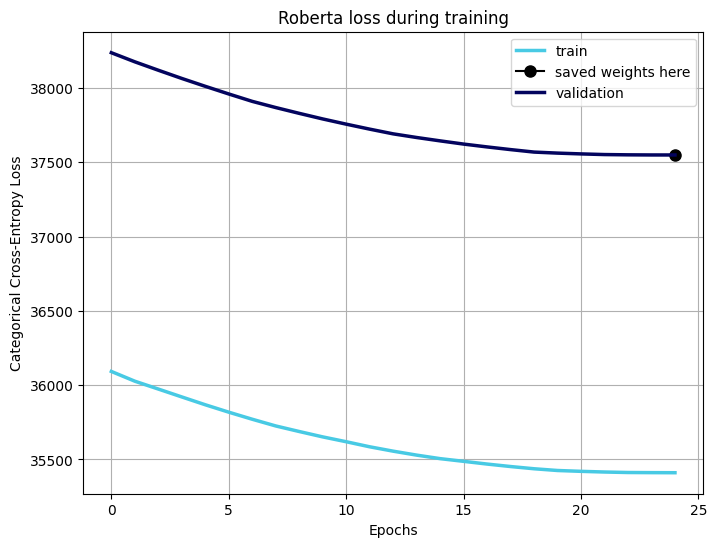

In [ ]:
# Plot training (and validation) loss
plt.figure(figsize=(8,6))
plt.plot(history['loss'], label='train', color='#48cae4', linewidth=2.5)

if len(history['val_loss']) > 0:
    plt.plot(history['smallest_val_loss'][0], history['smallest_val_loss'][1], marker="o", 
             label='saved weights here', markersize=8, color='black')
    plt.plot(history['val_loss'], label='validation', color='#03045e', linewidth=2.5)
    
plt.legend()
plt.title('Roberta loss during training')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# model_save_name = 'm2m100.pt(25)'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [25]:
model_save_name = 'm2m100.pt(25)'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [26]:
text = 'передбачення успішним'

# Tokenizer parameters
tokenizer_dict = dict(return_tensors = 'pt',
                      padding = 'max_length',
                      truncation = True,
                      max_length = max_token_length)

In [28]:
def highlight_text(text, color='yellow', padding='0.45em', margin='0.1em'):
  '''Add html markup & css style before and after text'''
  string = f'''<mark style="background: {color};
  padding: {padding};
  line-height: 2.5;
  text_align: center;
  border-radius: 0.35em;
  margin: {margin};">{text}</mark>'''

  return string

In [29]:
def predict_sequences(text, model, tokenizer, num_return_sequences, tokenizer_kwargs_dict):
    
    # Tokenize input text
    inputs = tokenizer(text, **tokenizer_kwargs_dict)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    # Generate model's prediction
    output_ids = model.generate(input_ids=input_ids, 
                                num_beams=10, 
                                num_return_sequences=num_return_sequences,
                                attention_mask=attention_mask
                               )
    
    # Decode model's output 
    output_strings = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    # === HTML-markup ===
    
    # Add html-headers
    s1_header = 'Source sentence'
    s2_header = 'Correction suggested by NN'
    
    # Div container for two rows
    html = '''
    <div style="display:flex; 
    flex-direction: row; 
    text-align: justify;
    border-radius: 7px;
    border: 2px dashed #8e9aaf;
    padding: 28px;">
    '''
    
    # Contents of the first, second columns respectively
    col1_html = f'''<div style="margin: 0 1em; width: 50%;"><h3>{s1_header}</h3>'''
    col2_html = f'''<div style="margin: 0 1em; width: 50%;"><h3>{s2_header}</h3>'''
    
    for output_str in output_strings:
        markup_s1, markup_s2 = '', ''
        
        # Use difflib module to find differences in two strings
        seq_matcher = dl.SequenceMatcher(None, text, output_str)
    
        # Iterate through indexes of equal / changed chunks of text
        for tag, i1, i2, j1, j2 in seq_matcher.get_opcodes():
            # Add equal elements without change
            if tag == 'equal':
              markup_s1 += text[i1:i2]
              markup_s2 += output_str[j1:j2]
            # Add changed chunks with html-markup
            else:
              markup_s1 += highlight_text(text[i1:i2], '#ffa8B6', padding='0.2em', margin='0')
              markup_s2 += highlight_text(output_str[j1:j2], '#9df9ef', padding='0.2em', margin='0')
                
        col1_html += f'''<p>{markup_s1}</p>'''
        col2_html += f'''<p>{markup_s2}</p>'''
        
    col1_html += '</div>'
    col2_html += '</div>'
    
    html += col1_html + col2_html + '</div>'
            
    display(HTML(html))



predict_sequences(text, model, tokenizer, 3, tokenizer_dict)

In [31]:
max_token_length=50

In [33]:
texts = [
    'я й не думав що лінгвіcтика це легко',
    'Слухай Остап чи не міг би ти купити мені червоний гуаш',
    'пятнадцять',
    'один мудрець вдало підмітив чим більше пізнаєш людей, тим більше починаєш любити тварин',
    'хочу подякувати учасників',
    'водій автобуса сказав пасажирам щоб вони оплати проїзд',
    'вона хотіла би навчатися малювання.',
    'концерт тривав майже півтора години',
    'він дбайливий по відношенню до майна',
    'учора був чудове день',
    'він за професії архітектор',
    'нажал я не знала про це',
    'це сама гірша ситуація',
    'ще б ми стільки прочитали сказала Василина' 
]

texts1 = ["вчора я пішов, у парк, з моїм собакою",
"на вечорі, всім сподобалася, музика",
"моя сестра купила, нову сумку, я бачив її",
"сьогодні, пішов до роботи, вчасно",
"ми грали, у футбол, на великому стадіоні",
"той хлопець, який вчора прийшов, дуже високий",
"ти можеш, мені допомогти, з цим завданням",
"вчора, побачив, свого друга, у магазині",
"це, найкращий ресторан, у місті",
"мій брат, любить грати, на гітарі",
"на вулиці, було дуже холодно, я надягнув світр",
"ми приїхали, на відпочинок, до гір",
"сьогодні, я почувався, дуже втомленим",
"твій подарунок, дуже сподобався, моїй сестрі",
"моя мама, готує смачний обід, на кухні",
"я завжди, пам'ятаю, свої друзів",
"учитель, запитав мене, про домашнє завдання",
"ми зустрілися, з нашими сусідами, у парку",
"сьогодні, я читав, цікаву книгу",
"твій брат, знає, як грати на фортепіано"]

#model.load_state_dict(history['best_model_wts'])


for text in texts:
    predict_sequences(text, model, tokenizer, 3, tokenizer_dict)

In [ ]:
model.load_state_dict(history['last_model_wts'])

for text in texts:
    predict_sequences(text, model, tokenizer, 3, tokenizer_dict)

In [57]:
inputs = tokenizer(text, **tokenizer_dict)
input_ids = inputs.input_ids.to(device)
attention_mask = inputs.attention_mask.to(device)
    
    # Generate model's prediction
output_ids = model.generate(input_ids=input_ids, 
                            num_beams=10, 
                            num_return_sequences=1,
                            attention_mask=attention_mask
                            )
    
    # Decode model's output 
output_strings = tokenizer.batch_decode(output_ids, skip_special_tokens=True)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (256) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


1.4853527680635705e-231
['ще б ми стільки прочитали сказала Василина'] ['Ще б ми стільки прочитали сказала Василина.']


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [63]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_score(reference_sentences, generated_sentences):
    total_bleu_score = 0
    for ref_sent, gen_sent in zip(reference_sentences, generated_sentences):
        ref_sent = ref_sent.split()  # Split the reference sentence into tokens
        gen_sent = gen_sent.split()  # Split the generated sentence into tokens
        bleu_score = sentence_bleu([ref_sent], gen_sent)
        total_bleu_score += bleu_score

    avg_bleu_score = total_bleu_score / len(reference_sentences)
    return avg_bleu_score

# Example usage
reference_sentences = ['This is a reference sentence 1.', 'This is a reference sentence 2.']
generated_sentences = ['This is a generated sentence 1.', 'This is a generated sentence 2.']

bleu_score = calculate_bleu_score(['ще б ми стільки прочитали сказала Василина'], output_strings)
print('BLEU score:', bleu_score)


BLEU score: 0.6147881529512643


In [14]:
from nltk.translate import gleu_score

def calculate_gleu_score(references, hypotheses):
    """
    Calculate the GLEU score for a list of reference sentences and generated sentences.
    Args:
        references (List[List[str]]): List of reference sentences, where each sentence is a list of tokens.
        hypotheses (List[List[str]]): List of generated sentences, where each sentence is a list of tokens.
    Returns:
        float: GLEU score.
    """
    total_score = 0.0
    num_sentences = len(references)

    for ref, hyp in zip(references, hypotheses):
        score = gleu_score.sentence_gleu([ref], hyp)
        total_score += score

    avg_score = total_score / num_sentences
    return avg_score


gleu_score = calculate_gleu_score(['один мудрець вдало підмітив чим більше пізнаєш людей, тим більше починаєш любити тварин'], ['Один мудрець вдало підмітив, що більше пізнаєш людей, тим більше починаєш любити тварин'])
print("GLEU score:", gleu_score)


GLEU score: 0.9298245614035088


In [36]:
user_sentence = input('Введіть, будь ласка, текст, що потребує корекції: ')
model_save_name = 'm2m100.pt(25)'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))
correct_sentence = predict_sequences(user_sentence, model, tokenizer, 3, tokenizer_dict)
print(correct_sentence)


Введіть, будь ласка, текст, що потребує корекції: вона бажав сьогодні гарного день


None
